In [1]:
from ogb.graphproppred import GraphPropPredDataset
from tqdm import tqdm
import networkx as nx
import numpy as np
from multiprocessing import Pool
import os
import matplotlib.pyplot as plt

In [2]:
dataset_name = 'ogbg-molfreesolv'

In [3]:
def graph_dict_to_nx_graph(
    graph_dict: dict
    ):
    """
    Constructs a NetworkX graph object from the given graph dictionary.

    Args:
        graph_dict: A dictionary representing a graph, with the following keys:
            - 'num_nodes': The number of nodes in the graph.
            - 'node_feat': A list of node features, with one feature vector per node.
            - 'edge_index': An edge index array of shape (2, E), where E is the number of edges.
            - 'edge_feat': A list of edge features, with one feature vector per edge.

    Returns:
        A NetworkX graph object with nodes and edges corresponding to the input graph.
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(graph_dict['num_nodes']))

    for node_number, features in enumerate(graph_dict['node_feat']):
        graph.add_node(node_number, feature=features)

    # change shape from (2, E) to (E, 2)
    edge_list = np.transpose(graph_dict['edge_index'])
    for node_number, (from_node, to_node) in enumerate(edge_list):
        features = graph_dict['edge_feat'][node_number]
        graph.add_edge(from_node, to_node, feature=features)

    return graph

In [4]:
def edges_to_nodes(
    graph:      nx.Graph
) -> nx.Graph:
    """
    Generates a new graph where each edge (u, v) is replaced with two edges
    (u, uv), (uv, v) and a new node uv. The attributes of the edge are
    copied to the new edge. This method may help if a graph embedding does
    not not support edge attributes.
    """
    new_graph = nx.Graph()
    max_node = max(list(graph.nodes))

    for node in nx.nodes(graph):
        new_graph.add_node(node)

        features = graph.nodes[node]
        new_graph.nodes[node].update(features)

    for u, v in nx.edges(graph):
        max_node += 1

        new_graph.add_node(max_node)
        new_graph.add_edge(u, max_node)
        new_graph.add_edge(max_node, v)

        features = graph.edges[u, v]
        new_graph.nodes[max_node].update(features)

    return new_graph

In [5]:
def get_graph(graph_dict):
    return edges_to_nodes(graph_dict_to_nx_graph(graph_dict))

In [6]:
# get graph_dicts and labels
dataset = GraphPropPredDataset(name=dataset_name)
split_idx = dataset.get_idx_split()

graph_dicts = []
labels = []
for graph_dict, label in tqdm(dataset):
    graph_dicts.append(graph_dict)
    labels.append(label)

100%|██████████| 642/642 [00:00<00:00, 533850.75it/s]


In [7]:
# get nx graphs
graphs = []
with Pool() as pool:
    for graph in tqdm(
        pool.imap(get_graph, graph_dicts), 
        total=len(graph_dicts)
    ):
        graphs.append(graph)

100%|██████████| 642/642 [00:00<00:00, 1783.13it/s]


In [8]:
from karateclub import Graph2Vec

model = Graph2Vec(
    attributed=True,
    dimensions=256,
    wl_iterations=6,
    epochs=30,
    workers=len(os.sched_getaffinity(0))
)
model.fit(graphs)
X = model.get_embedding()

In [9]:
y = np.array(labels)

In [14]:
import numpy as np

X_train = np.array([X[i] for i in split_idx['train']])
y_train = np.array([y[i] for i in split_idx['train']]).ravel()

X_test = np.array([X[i] for i in split_idx['test']])
y_test = np.array([y[i] for i in split_idx['test']]).ravel()

X_valid = np.array([X[i] for i in split_idx['valid']])
y_valid = np.array([y[i] for i in split_idx['valid']]).ravel()

In [11]:
import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    memory_limit=9999
)
automl.fit(X_train, y_train, X_test=X_test, y_test=y_test)

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     memory_limit=9999, per_run_time_limit=30,
                     time_left_for_this_task=120)

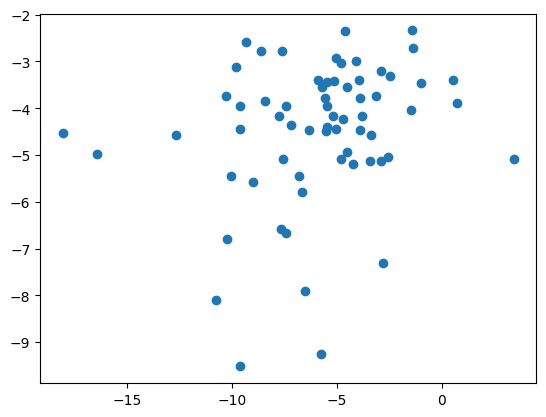

In [12]:
y_test_pred = automl.predict(X_test)
plt.scatter(y_test, y_test_pred)

In [19]:
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name = dataset_name)
input_dict = {"y_true": y_valid.reshape(-1, 1), "y_pred": automl.predict(X_valid).reshape(-1, 1)}
result_dict = evaluator.eval(input_dict)
result_dict

{'rmse': 5.8117738124106495}